In [1]:
%matplotlib inline
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import mio
import os, glob, random, sys
import shapely
global geom1, geom2

In [2]:
def cutpoint(p1:tuple, p2:tuple)->tuple:
    "calc point cuts zero plane"
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if (z2 - z1) != 0:
        k = - z1 / (z2 - z1)
    else:
        k = 0
    x0 = x1 + k * (x2 - x1)
    y0 = y1 + k * (y2 - y1)
    z0 = z1 + k * (z2 - z1)
    return x0, y0, z0

In [3]:
def slice_line(p1:tuple, p2:tuple)->list:
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if z1>0 and z2>0:
        # line above zero plane
        return [(x1, y1, 0), (x2, y2, 0)]
    if z1<0 and z2<0:
        # Line below zero plane
        return []
    p0 = cutpoint(p1, p2)
    if z1<=0:
        # replace first point
        return [p0, p2]
    if z2<=0:
        # replace second point
        return [p1, p0]

In [4]:
def slice_tri(poly:Polygon, h:float, tri_buffer:float):
    " Slice one triangle"
    p1 =   poly.exterior.coords[0]
    p2 =   poly.exterior.coords[1]
    p3 =   poly.exterior.coords[2]
    p1 = [p1[0], p1[1], p1[2]-h]
    p2 = [p2[0], p2[1], p2[2]-h]
    p3 = [p3[0], p3[1], p3[2]-h]
    l = []
    l1 = slice_line(p1, p2)
    l2 = slice_line(p2, p3)
    l3 = slice_line(p3, p1)
    l = l1 + l2 + l3
    # aribitrary buffer to avoid topology errors (1 cm!)
    poly = Polygon(l).buffer(tri_buffer)
    if poly.area == 0:
        return
    
    return poly

In [5]:
def make_level(tri:list, h:float, tri_buffer:float):
    pl = []
    for t in tri:
        poly = Polygon(t)
        poly = slice_tri(poly, h, tri_buffer)
        if poly is not None:   # avoid empty polygons
            pl.append(poly)
    gdf = gpd.GeoDataFrame(geometry=pl)

    gdf = make_coord_int(gdf, 1)

    # try to fix topology error
    gdf.geometry = gdf.geometry.buffer(0)
    
    geom = gdf.geometry.unary_union
    
    return geom


In [6]:
def read_obj_file(model_path:str)->tuple:
    # read obj file
    fin = open(model_path)
    v_list = []
    f_list = []
    for s in fin:
        l = s.split()
        if l[0] == 'g':
            lon = float(l[1])
            lat = float(l[2])
        if l[0] == 'v':
            vertex = float(l[1]), float(l[2]),float(l[3])
            v_list.append(vertex)                                    
        if l[0] == 'f':
            poi = l[1:]
            poi = [int(x)-1 for x in poi]
            f_list.append(poi)
    return v_list, f_list, lon, lat

In [7]:
def resolve_tris(v_list:list, f_list:list)->list:
    tris = []
    for f in f_list:
        tri = [v_list[p] for p in f]
        tris.append(tri)
    return tris

In [8]:
def get_hight_range(tris:list)->tuple:
    h_min = 8848
    h_max = 0
    for tri in tris:
        for point in tri:
            h = point[2]
            if h > h_max: h_max = h
            if h < h_min: h_min = h
    return h_min, h_max

In [9]:
def levels_df(tris:list, tri_buffer:float, min_dif:float) -> gpd.GeoDataFrame:
    h_min, h_max = get_hight_range(tris)
    h_min = int(h_min-1)
    h_max = int(h_max+1)
    gl = []
    area = 0
    for h in range(h_min, h_max):
        row = {}
        row['h'] = h
        row['geometry'] = make_level(tris, h, tri_buffer)
        if row['geometry'].area>0:
            gl.append(row)
    gdf = gpd.GeoDataFrame(gl)
    gdf = gdf.iloc[::-1]
    gdf = gdf.reset_index(drop=True)
    return gdf.copy()

In [10]:
def make_v_f(row:gpd.GeoSeries)->list:
    v_list = []
    f_list = []
    i = 0
    for coord in row.geometry.exterior.coords:
        i += 1
        xyz = (coord[0], coord[1], row.h)
        v_list.append(xyz)
        f_list.append(i)
    return v_list, f_list

In [11]:
def write_level_obj(gdf:gpd.GeoDataFrame, obj_dest:str):
    fout = open(obj_dest, 'w')
    fout.write('g\n')
    i_offset = 0
    for ind, row in gdf[:].iterrows():
        v_list, f_list = make_v_f(row)
        for coord in v_list:
            s = "v %f %f %f\n" % coord
            fout.write(s)
        sv = 'f '
        for i in f_list:
            sv = sv + " " + str(i + i_offset)
        fout.write(sv + "\n")
        i_offset += len(f_list)
    fout.close()

In [12]:
def cut_out(gdf:gpd.GeoDataFrame, factor:int, cut_buffer:float):
    gdf = gdf.copy()
    gdf = gdf[gdf.geometry.area>0]
    gdf.geometry = gdf.geometry.buffer(0)
    gdf = make_coord_int(gdf, factor)
    for i in range(len(gdf)-1):
        gdf = make_coord_int(gdf, 1)
        upper_gl = gdf.geometry.iloc[0:i+1]
        lower_gl = gdf.geometry.iloc[i+1:]
        
        geom = upper_gl.unary_union.buffer(cut_buffer)
        assert geom.is_valid
        
        try:
            lower_cut_gl = lower_gl.buffer(0).difference(geom)
        except:
            global geom1, geom2 
            geom1, geom2 = lower_gl, geom
            raise Exception('Error in cut_out(), saved in geom1, geom2')

        
        lower_cut_gl = lower_cut_gl.buffer(0)
               
        res_gl = upper_gl.append(lower_cut_gl)
        gdf.geometry = res_gl
        gdf.geometry.buffer(0)
        
        
    return gdf.copy()

In [13]:
def make_coord_int(gdf:gpd.GeoDataFrame(), factor:int):
    def trans(x,y,z):
        x = round(x * factor)
        y = round(y * factor)
        z = 0
        return x,y,z
    gl = []
    for geom in gdf.geometry:
        geom2 = shapely.ops.transform(trans, geom)
        gl.append(geom2)
    res = gpd.GeoDataFrame(gdf, geometry=gl)
    res.geometry = res.geometry.buffer(0)
    return res

In [14]:
def list_int(v_list:list, factor:int):
    res = []
    for coord in v_list:
        x = round(coord[0] * factor)
        y = round(coord[1] * factor)
        z = round(coord[2] )
        res.append( (x, y, z))
    return res

In [15]:
file_list = glob.glob('obj/*.obj')[0:100]
for i, obj_file in enumerate(file_list):
    json_file = "json/" + mio.file_title(obj_file) + '.json'
    mio.show_perc(i, len(file_list), 10)
    v_list, f_list, lon, lat = read_obj_file(obj_file)
    v_list = list_int(v_list, 100)
    tris = resolve_tris(v_list, f_list)
    gdf = levels_df(tris, tri_buffer=0, min_dif=0)
    gdf = cut_out(gdf, 1, cut_buffer=0)
    gdf = gdf[gdf.geometry.area>0].copy()
    gdf = mio.disagg(gdf)
    gdf.geometry = gdf.geometry.buffer(0)
    gdf['lon'] = lon
    gdf['lat'] = lat
    gdf['model_path'] = obj_file
    gdf.to_file(json_file, driver="GeoJSON")

0.0% 

C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 

TopologyException: found non-noded intersection between LINESTRING (-56 722, -59 747) and LINESTRING (-59 747, -50 671) at -59 747 0


Exception: Error in cut_out(), saved in geom1, geom2

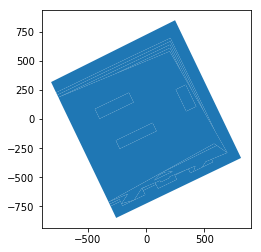

In [20]:
# check
l = glob.glob('json/*.json')
file = random.choice(l)
gdf = gpd.read_file(file, driver="GeoJSON")
gdf.plot()

In [17]:
def obj_to_json(model_path:str, dest:str)->gpd.GeoDataFrame:
    v_list, f_list, lon, lat = read_obj_file(model_path)
    v_list = list_int(v_list, 10)
    tris = resolve_tris(v_list, f_list)
    gdf = levels_df(tris, tri_buffer=0, min_dif=0)
    #gdf = cut_out(gdf, 10, cut_buffer=0)
    return 

    gdf = mio.disagg(gdf)
    gdf.geometry = gdf.geometry.buffer(0)
    gdf['lon'] = lon
    gdf['lat'] = lat
    gdf['model_path'] = model_path
    gdf.to_file(dest, driver="GeoJSON")
    return gdf

In [18]:
file_list = glob.glob('obj/*.obj')
for i, obj_file in enumerate(file_list):
    mio.show_perc(i, len(file_list), 10)
    json_file = os.path.splitext(obj_file)[0] + '.json'
    obj_to_json(obj_file, json_file)

0.0% 0.08% 0.15% 0.23% 0.3% 0.38% 0.45% 

IndexError: index out of bounds

In [ ]:
geom1.area>0

In [43]:
test = gpd.GeoDataFrame(geometry=[geom2])
mio.write_tab(test, 'test.tab')

1 rows of type MultiPolygon written to mapinfo file.


C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


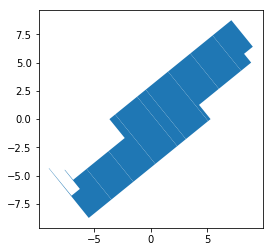

In [18]:
# check
l = glob.glob('json/1091/*.json')
file = random.choice(l)
gdf = gpd.read_file(file, driver="GeoJSON")
gdf.plot()

In [7]:
mio.write_tab(gdf, 'levels.tab')

11 rows of type MultiPolygon written to mapinfo file.


C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
